## Summary
1) Try removing high-correlated features. 

2) Try tweaking random forest parameters.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
from copy import deepcopy

sns.set_context('poster')
%matplotlib inline

In [34]:
loc = '/Users/elena/Documents/Kaggle/Allstate/data/'
train = pd.read_csv(loc+'train.csv')
train.drop('id',axis=1,inplace=True)

test = pd.read_csv(loc+'test.csv')
ids = test.loc[:,'id']

In [3]:
# List of categorical columns
keepcats = [col for col in train.columns if 'cat' in col]
# List of continuous columns
keepcont = [col for col in train.columns if 'cont' in col]

print 'Categorical: ',len(keepcats)
print 'Continuous: ',len(keepcont)

Categorical:  116
Continuous:  14


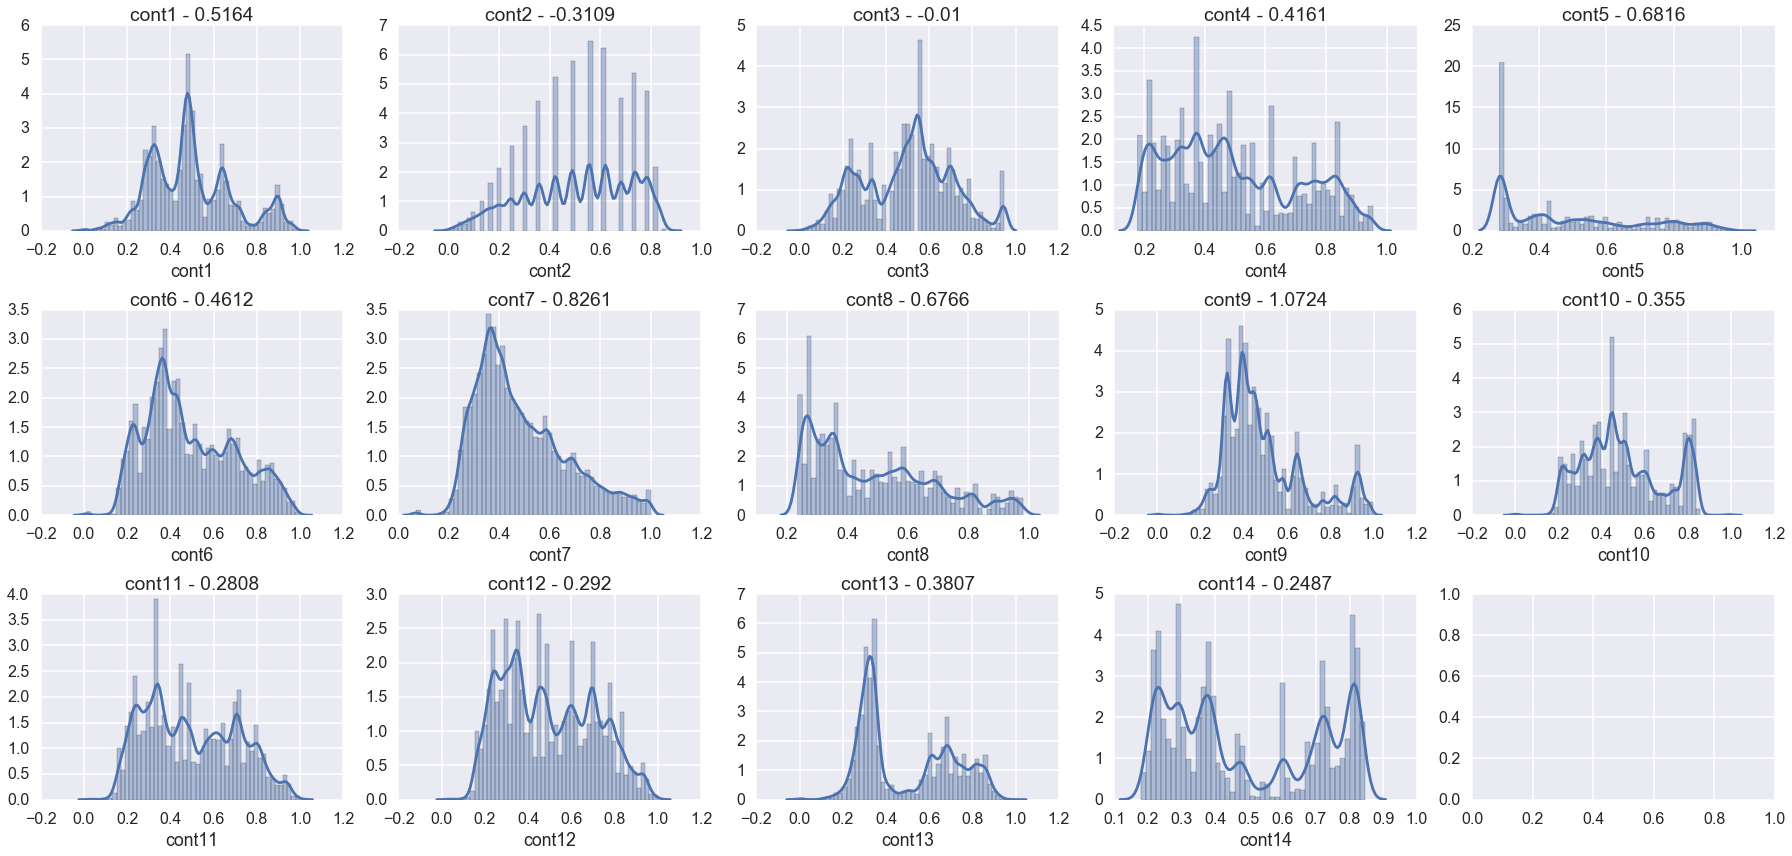

In [4]:
fig, axes = plt.subplots(3,5)
fig.set_size_inches(25, 12)
a = 1
for column in keepcont:
    sk= train[column].skew()
    
    plt.subplot(3,5,a)
    sns.distplot(train[column])
    plt.title(column+' - '+str(round(sk,4)))
    a+=1
    
plt.tight_layout()

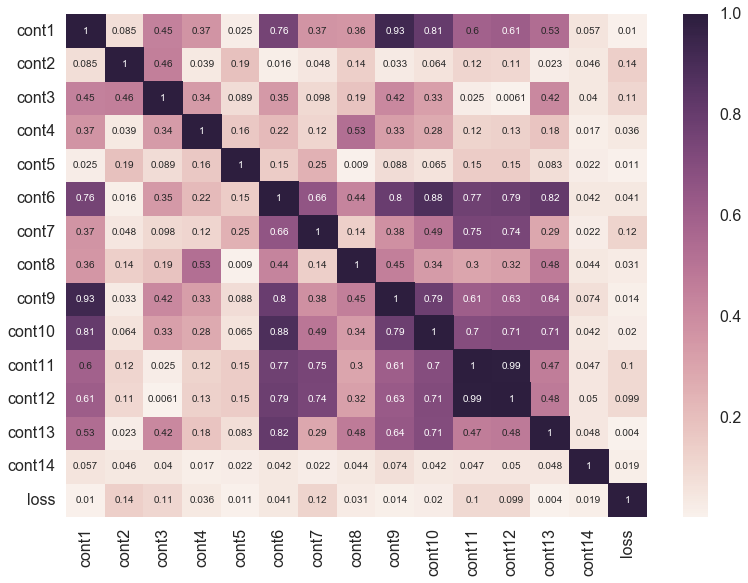

In [5]:
contFeatureslist = deepcopy(keepcont)
contFeatureslist.append("loss")
correlationMatrix = train[contFeatureslist].corr().abs()

plt.subplots(figsize=(13, 9))
sns.heatmap(correlationMatrix,annot=True)

# Mask unimportant features
sns.heatmap(correlationMatrix, mask=correlationMatrix < 1, cbar=False)

plt.show()

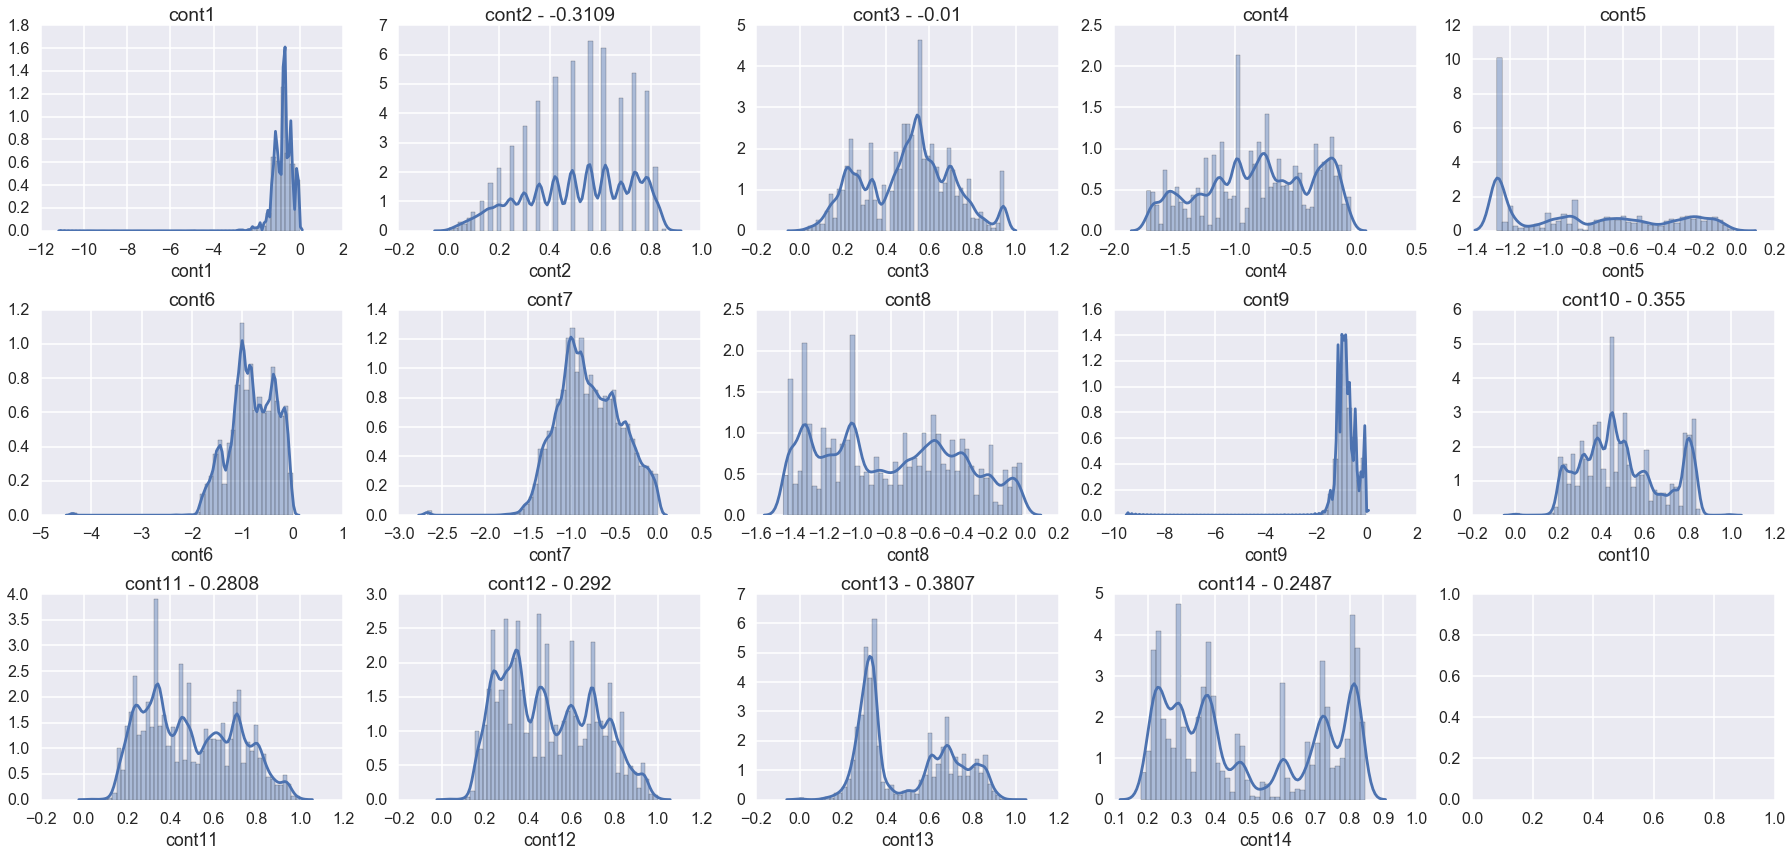

In [6]:
fig, axes = plt.subplots(3,5)
fig.set_size_inches(25, 12)
a = 1
for column in keepcont:
    sk = train[column].skew()
    
    plt.subplot(3,5,a)
    if (sk>0.40) | (sk<-0.40):
        dat = np.log(train[column])
        dat[dat==np.inf]=np.nan
        sns.distplot(dat)
        plt.title(column)
    else:
        sns.distplot(train[column])
        plt.title(column+' - '+str(round(sk,4)))
    a+=1
    
plt.tight_layout()

In [7]:
# Get rid of 1 or 9, 11 or 12, 6 or 10,
# transform 6, 7, and 9/1. 

newlist = deepcopy(keepcont)
newlist.remove("cont1")
newlist.remove("cont11")
newlist.remove("cont6")
newlist.append("loss")

dataset = train[newlist]
dataset.head()

,cont2,cont3,cont4,cont5,cont7,cont8,cont9,cont10,cont12,cont13,cont14,loss
0,0.245921,0.187583,0.789639,0.310061,0.335060,0.30260,0.67135,0.83510,0.594646,0.822493,0.714843,2213.18
1,0.737068,0.592681,0.614134,0.885834,0.436585,0.60087,0.35127,0.43919,0.366307,0.611431,0.304496,1283.60
2,0.358319,0.484196,0.236924,0.397069,0.315545,0.27320,0.26076,0.32446,0.373424,0.195709,0.774425,3005.09
3,0.555782,0.527991,0.373816,0.422268,0.391128,0.31796,0.32128,0.44467,0.321570,0.605077,0.602642,939.85
4,0.159990,0.527991,0.473202,0.704268,0.247408,0.24564,0.22089,0.21230,0.202213,0.246011,0.432606,2763.85


/Users/elena/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/elena/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


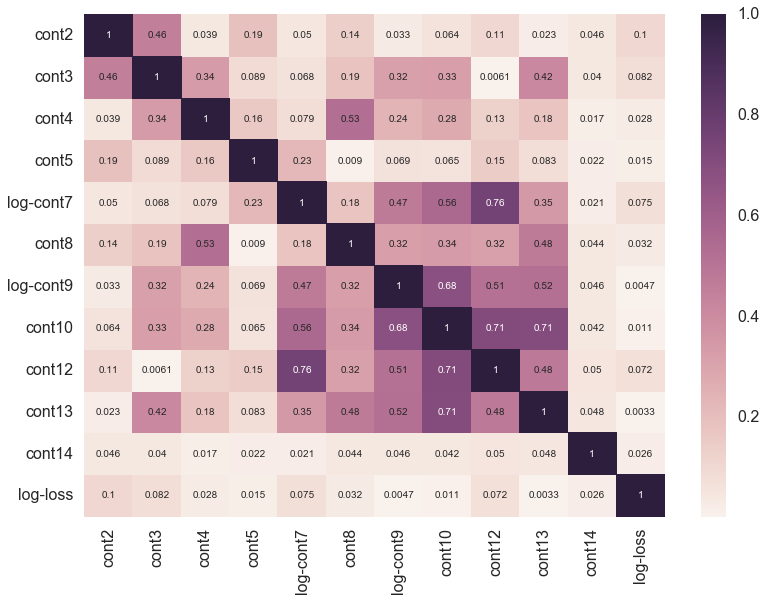

In [8]:
vals_to_log = list(["cont7","cont9","loss"])
for col in vals_to_log:
    dataset.loc[:,col]=np.log(dataset.loc[:,col])
    dataset.rename(columns={col:'log-'+col},inplace=True)
    
correlationMatrix2 = dataset.corr().abs()

plt.subplots(figsize=(13, 9))
sns.heatmap(correlationMatrix2,annot=True)

# Mask unimportant features
sns.heatmap(correlationMatrix2, mask=correlationMatrix2 < 1, cbar=False)
plt.show()

### Random Forest
continuous data only, transformed some highly-skewed variables.

In [10]:
model = RandomForestRegressor(n_estimators=50)
x = dataset[list(dataset.columns[:-1])]
print list(dataset.columns[:-1])
y = dataset['log-loss']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.75)

model.fit(X_train,y_train)
x_pred = model.predict(X_test)
# for col in vals_to_log[:-1]:
#     x_pred.loc[:,col]=np.log(x_pred.loc[:,col])

mae = mean_absolute_error(np.exp(y_test),np.exp(x_pred))
print mae

['cont2', 'cont3', 'cont4', 'cont5', 'log-cont7', 'cont8', 'log-cont9', 'cont10', 'cont12', 'cont13', 'cont14']
1870.54110366


### Categorical data

In [38]:
# labels = []
# cols = train.columns

# for i in range(0,116):
#     trainer = train[cols[i]].unique()
#     tester = test[cols[i]].unique()
#     labels.append(list(set(trainer) | set(tester)))    


# #Import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OneHotEncoder

# #One hot encode all categorical attributes
# cats = []
# for i in range(0, 116):
#     #Label encode
#     label_encoder = LabelEncoder()
#     label_encoder.fit(labels[i])
#     feature = label_encoder.transform(train.iloc[:,i])
#     feature = feature.reshape(train.shape[0], 1)
    
    
#     #One hot encode
#     onehot_encoder = OneHotEncoder(sparse=False,n_values=len(labels[i]))
#     feature = onehot_encoder.fit_transform(feature)
#     cats.append(feature)
#     print feature.shape

# # Make a 2D array from a list of 1D arrays
# encoded_cats = np.column_stack(cats)

# # Print the shape of the encoded data
# print(encoded_cats.shape)

# #Concatenate encoded attributes with continuous attributes
# dataset_encoded = numpy.concatenate((encoded_cats,dataset.iloc[:,split:].values),axis=1)

(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)
(188318, 1)
(188318, 2)


KeyboardInterrupt: 

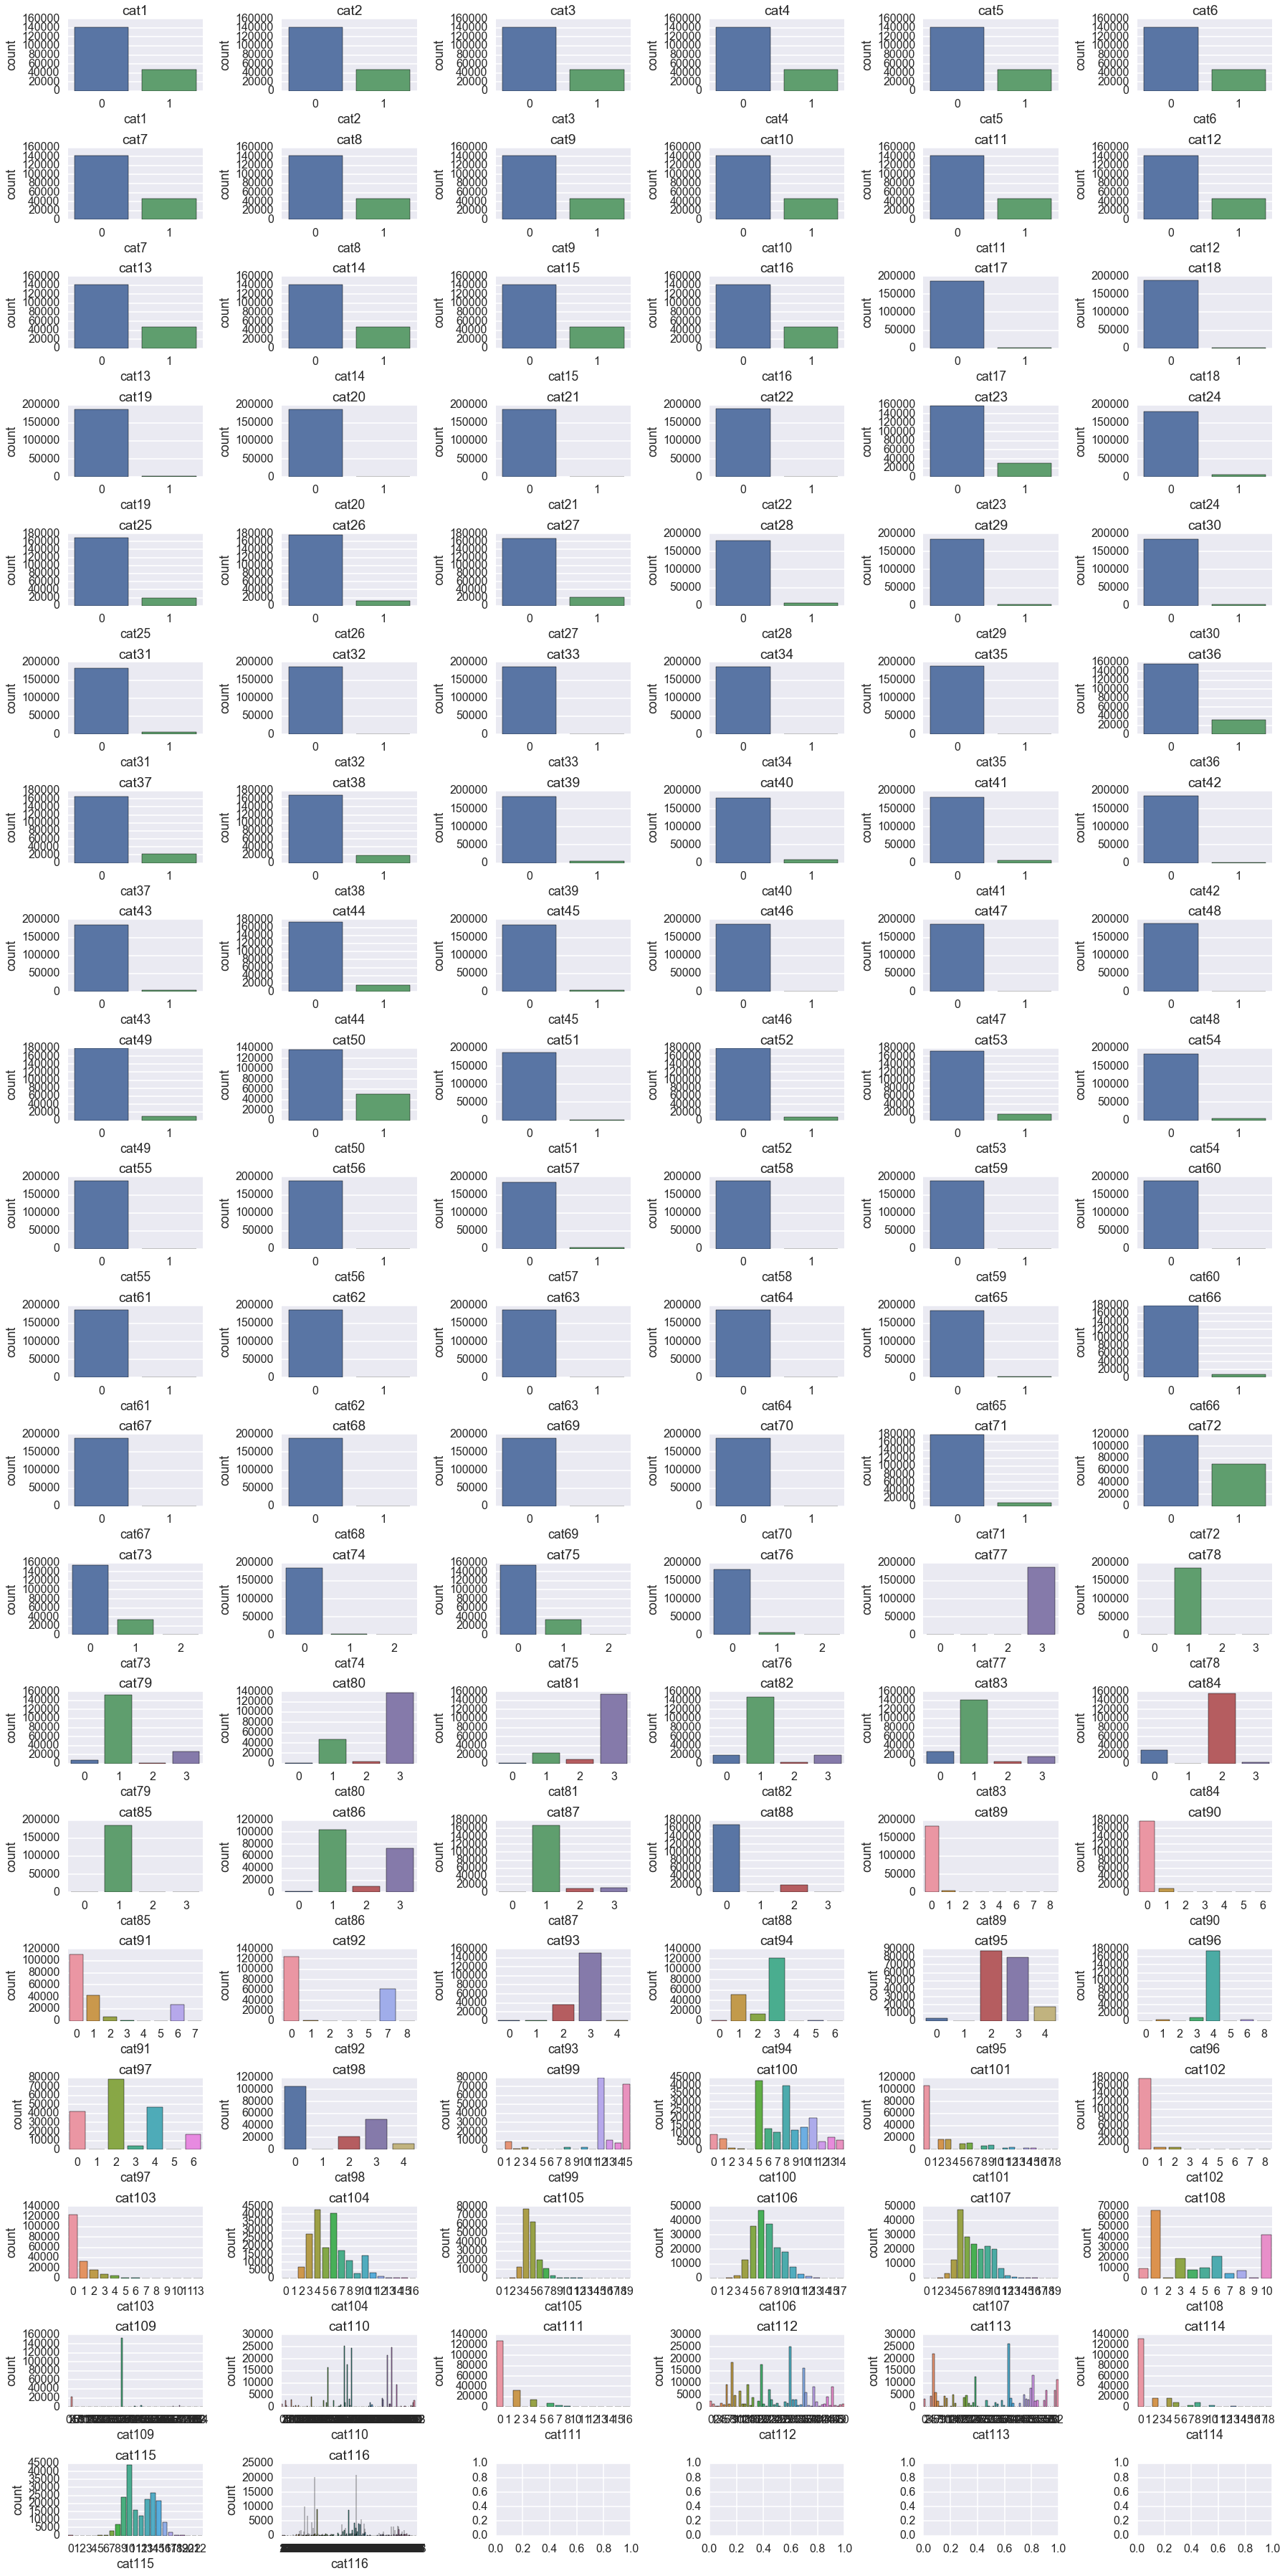

In [13]:
fig, axes = plt.subplots(20,6)
fig.set_size_inches(25, 50)
a = 1
for column in keepcats:
    # Want to make sure the categorical data is converted to strings using
    # both the test and train dataset (so we know the full range of values)
    # used for each category. (i.e. there aren't any A's in train['cat1'], but there's
    # an A in test['cat1'])
    
    plt.subplot(20,6,a)
    sns.countplot(train[column])
    plt.title(column)
    a+=1
    
    # Convert train and test data to integers:
    alldat = np.concatenate((train.loc[:,column].values,test.loc[:,column].values),axis=0)
    converted = convert_strings(alldat)
    train.loc[:,column]=converted[0:len(train)]
    test.loc[:,column]=converted[len(train):]
    
plt.tight_layout()

In [22]:
cat_to_keep = list(["cat8","cat21","cat72","cat75","cat77",
                   "cat78","cat81","cat84","cat86","cat91"])
for j in range(94,117):
    cat_to_keep.append("cat"+str(j))
print cat_to_keep

['cat8', 'cat21', 'cat72', 'cat75', 'cat77', 'cat78', 'cat81', 'cat84', 'cat86', 'cat91', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat115', 'cat116']


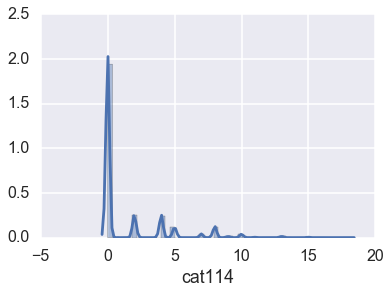

In [27]:
sns.distplot(train.loc[:,'cat114'])